In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import randint
from functools import partial

from scipy.optimize import minimize_scalar
from statsmodels.tsa.api import  SimpleExpSmoothing

%matplotlib inline



In [2]:
# %pip install ipdb

In [3]:
import ipdb
# Basic parameters

In [4]:
def dbl_SEWMA(data, alpha):
    mod1 = SimpleExpSmoothing(data, initialization_method="heuristic").fit(smoothing_level=alpha, optimized=False)
    return mod1.sse
bound_set = np.linspace(0,1,10)
bound_set = [0.0,.13,.154,.139,.31,.76]

# fit_res = {}
# for j in bound_set:
#     fit_res[j] = oil_SEWMA(j)

# fit_check = pd.Series(fit_res)
# result = fit_check.index[fit_check.argmin()]

# oil_SEWMA = lambda a: dbl_SEWMA(data=oildata, alpha=a)

In [5]:
def flat_with_noise(start_value=10., n_years=5, chgrat=0.20):
    # function to produce a level change
    output = np.zeros(n_years) + start_value
    chgsize = chgrat*start_value
    dmin = int(-1*chgsize)
    dmax = int(chgsize)
    output += np.array([randint(dmin, dmax) for x in range(n_years)])
    return(output)

In [6]:
def impulse(start_value=10., n_years=5, impyr=2, chgrat=.670, impsign=1):
    # function to produce an impulsive change 
    chgsize = chgrat*start_value
    out = np.array([start_value for x in range(n_years)]) 
    out[impyr:n_years] = impsign*chgsize +  out[impyr]
    return(out)

In [7]:
def cvx_change(start_value=10., n_years=5, chgsign=1, chgrat=.20):
    #function to produce convex change 
    # i.e. change where the time series of population falls below the line connecting any two 
    # points on the time series, i.e. alpha*exp(t) or alpha*exp(n_years - t)
    chgsize = chgrat*start_value
    
    alpha = np.exp(np.log(1+chgsign*chgrat)/n_years) - 1
    output = start_value * np.power(1. + alpha, np.linspace(1,n_years,n_years))
    
    return(output)

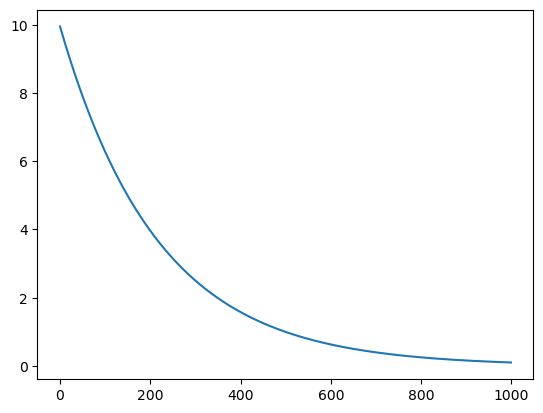

In [8]:
plt.plot(cvx_change(n_years=1000,chgrat=.99,chgsign=-1))

In [9]:
def ccv_change(start_value=10.,n_years=5,alpha=0.75,chgsign=1, chgrat=.20):
    #function to produce convex change 
    # i.e. change where the time series of population falls below the line connecting any two 
    # points on the time series, i.e. alpha*exp(t) or alpha*exp(n_years - t)
    adjust = 0.5*np.pi if chgsign < 0 else 0
    out = np.linspace(0,0.5*np.pi, n_years+1)
    out += adjust
    maxi = (1+chgrat*chgsign)*start_value
    mini = min(start_value, maxi)
    maxi = max(start_value, maxi)
    output = (maxi-mini)*np.sin(out) + mini
    return(output[1:])

In [10]:
sscRat = 100
tolerance = (-0.5, 0.25)
Alphas = np.linspace(.1,1,10)
pselect = [0.1 for x in Alphas]
growthPats = {'flat':flat_with_noise, 
              'impUp':impulse, 
              'impDn':partial(impulse, impsign=-1), 
              'cvxUp':cvx_change, 
              'cvxDn':partial(cvx_change, chgsign=-1),
              'ccvUp':ccv_change,
              'ccvDn':partial(ccv_change, chgsign=-1)
              }
NSchool = 11
len_history = 50

In [11]:
def simulate_history(start_value=50, total_years=50, period_length=5):
    history = [[start_value for x in range(period_length)]]
            # need to add functionality to smooth the transitions 
    
    for _, tp in enumerate(range(total_years//period_length)):
        locidx = randint(0,len(growthPats)-1) # there are 7 locidxs
        # locidx = 6 # 4 and 6 need work
        print(f"starting history {locidx}, a/k/a {repr(list(growthPats.values())[locidx])}")
        print(_)
        lochg = history[_][period_length-1] 
        print(lochg)
        # ipdb.set_trace()
        locfun = list(growthPats.values())[locidx](start_value=lochg, n_years=period_length) 
        local_h = np.squeeze(locfun)
        # local_h = local_h[1:len(local_h) ]
        print(local_h)
        history.append(local_h)
        print("____")

    out = np.floor(np.hstack(history)[period_length:])
    print(out)
    return out[period_length:]


starting history 5, a/k/a <function ccv_change at 0x000001BE0A7AD580>
0
5000
[5130.52619222 5258.8190451  5382.68343237 5500.         5608.76142901
 5707.10678119 5793.35334029 5866.02540378 5923.87953251 5965.92582629
 5991.44486137 6000.        ]
____
starting history 4, a/k/a functools.partial(<function cvx_change at 0x000001BE04D2DDA0>, chgsign=-1)
1
6000.0
[5889.45917924 5780.95490399 5674.44965402 5569.90660034 5467.28959248
 5366.563146   5267.6924302  5170.64325608 5075.38206451 4981.87591467
 4890.09247258 4800.        ]
____
starting history 5, a/k/a <function ccv_change at 0x000001BE0A7AD580>
2
4799.999999999999
[4925.30514453 5048.4662833  5167.37609507 5280.         5384.41097185
 5478.82250994 5561.61920668 5631.38438763 5686.92435121 5727.28879324
 5751.78706692 5760.        ]
____
starting history 4, a/k/a functools.partial(<function cvx_change at 0x000001BE04D2DDA0>, chgsign=-1)
3
5759.999999999999
[5653.88081207 5549.71670783 5447.47166786 5347.11033632 5248.59800878


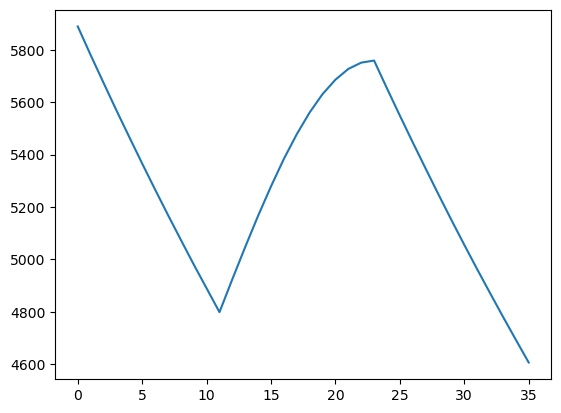

In [12]:
plt.plot(simulate_history(start_value=5000,period_length=12))

In [13]:
(430-536)/536


-0.19776119402985073

In [14]:
JJ


NameError: name 'JJ' is not defined